In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.6/dist-packages (1.7.0)


In [2]:
import collections
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, np, npx
import os
import random
import time
import zipfile

npx.set_np()

In the WikiText-2 dataset,
each line represents a paragraph where
space is inserted between any punctuation and its preceding token.
Paragraphs with at least two sentences are retained.
To split sentences, we only use the period as the delimiter for simplicity.
We leave discussions of more complex sentence splitting techniques in the exercises
at the end of this section.


In [3]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [4]:
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [5]:
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        #print('tokens',tokens)
        #print('segments',segments)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [6]:
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # Make a new copy of tokens for the input of a masked language model,
    # where the input may contain replaced '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.randint(0, len(vocab) - 1)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [7]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [8]:
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(np.array(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype='int32'))
        all_segments.append(np.array(segments + [0] * (
            max_len - len(segments)), dtype='int32'))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(np.array(len(token_ids), dtype='float32'))
        all_pred_positions.append(np.array(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype='int32'))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            np.array([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)), dtype='float32'))
        all_mlm_labels.append(np.array(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype='int32'))
        nsp_labels.append(np.array(is_next))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [9]:
#@save
class _WikiTextDataset(gluon.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [10]:
#@save
def load_data_wiki(batch_size, max_len):
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                       num_workers=num_workers)
    return train_iter, train_set.vocab

In [41]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

(512, 64) (512, 64) (512,) (512, 10) (512, 10) (512, 10) (512,)


In the end, let us take a look at the vocabulary size.
Even after filtering out infrequent tokens,
it is still over twice larger than that of the PTB dataset.


In [42]:
tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y=iter(train_iter).next()

In [47]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [48]:
import pandas as pd
import numpy as np
import torch
import torchtext
from torchtext.data import Field, BucketIterator
import torch.nn as nn
import torch.nn.functional as F

In [49]:
n_layer=1
n_layer=1
class My_RNN_back(nn.Module):

    def __init__(self, embed_dim,hidden_dim, drop_p):
        super(My_RNN_back, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim,
                        num_layers=1, dropout=drop_p,bidirectional=True)

    def forward(self, inputs, text_lengths):
        
        #print(inputs.shape)

        text_lengths = text_lengths.cpu()

        batch_size = inputs.size()[1]

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(inputs, text_lengths, enforce_sorted = False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        outputs = outputs.view(-1, batch_size, 2, self.hidden_dim)
        temp_outputs = torch.zeros(inputs.size(0), batch_size, 2, self.hidden_dim, device=device )
        temp_outputs[:outputs.shape[0],:,:,:] = outputs
        outputs = temp_outputs
        return outputs[:,:,1,:].view(-1, batch_size, self.hidden_dim)

class My_RNN(nn.Module):

    def __init__(self, embed_dim,hidden_dim,drop_p):
        super(My_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_size=embed_dim+hidden_dim, hidden_size=hidden_dim,
                        num_layers=1, dropout=drop_p,bidirectional=False)#True)

    def forward(self, inputs, hidden_backward, text_lengths):
        
        text_lengths = text_lengths.cpu()
        #print('inputs_shape',inputs.shape)
        #print('hidden_shape',hidden_backward.shape)
        batch_size = inputs.size()[1]
        inputs=torch.cat([inputs,hidden_backward],2)
        #print(inputs.shape)

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(inputs, text_lengths, enforce_sorted = False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        temp_outputs = torch.zeros(inputs.size(0), batch_size, self.hidden_dim, device=device )
        temp_outputs[:outputs.shape[0],:,:] = outputs
        outputs = temp_outputs
        return outputs #ht[-2:].transpose(0, 1).contiguous().view(batch_size, -1)  

class My_RNN1(nn.Module):

    def __init__(self, embed_dim,hidden_dim,drop_p):
        super(My_RNN1, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_size=embed_dim+hidden_dim, hidden_size=hidden_dim,
                        num_layers=1, dropout=drop_p,bidirectional=False)#True)

    def forward(self, inputs, hidden_backward, text_lengths):

         
        text_lengths = text_lengths.cpu()

        batch_size = inputs.size()[1]

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(inputs, text_lengths, enforce_sorted = False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        outputs, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        #print(outputs.shape)

        #outputs=outputs.view(-1,batch_size,2,self.hidden_dim)


        return outputs[-1,:,:].view(batch_size, -1) #ht[-2:].transpose(0, 1).contiguous().view(batch_size, -1)    


class My_Bi_LSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, drop_p, n_layers=1):
        super(My_Bi_LSTM, self).__init__()
        self.rnn_back=[]
        self.rnn=[]
        self.n_layers=n_layers
        for i in range(int(n_layers)):
            if (i==0):   
                self.rnn_back.append(My_RNN_back(embed_dim,hidden_dim, drop_p).to(device))
                self.rnn.append(My_RNN(embed_dim,hidden_dim, drop_p).to(device))
            else:   
                self.rnn_back.append(My_RNN_back(2*hidden_dim,hidden_dim, drop_p).to(device))
                self.rnn.append(My_RNN(hidden_dim,hidden_dim, drop_p).to(device))
        self.rnn_back = nn.ModuleList(self.rnn_back)
        self.rnn = nn.ModuleList(self.rnn)

    def forward(self, embeddings, embeddings_len):
        
        temp_output=embeddings
        
        batch_size = embeddings.size()[1]
        
        for i in range(self.n_layers):
            
            
            hid_back=self.rnn_back[i](temp_output, embeddings_len)
            out1 = self.rnn[i](temp_output, hid_back, embeddings_len)
            temp_output=torch.cat([hid_back, out1], 2)
        return temp_output



# class My_Bi_LSTM(nn.Module):
#     def __init__(self,embed_dim,hidden_dim,drop_p,n_layers=1):
#         super(My_Bi_LSTM, self).__init__()
#         self.rnn_back=[]
#         self.rnn=[]
#         self.n_layers=n_layers
#         for i in range(n_layers):
#             if (i==0):
#                 self.rnn_back.append(My_RNN_back(embed_dim,hidden_dim, drop_p).to(device))
#                 self.rnn.append(My_RNN(embed_dim,hidden_dim, drop_p).to(device))
#             else:   
#                 self.rnn_back.append(My_RNN_back(hidden_dim*2,hidden_dim, drop_p).to(device))
#                 self.rnn.append(My_RNN(hidden_dim*2,hidden_dim, drop_p).to(device))

#     def forward(self, embeddings,embeddings_len):
#         temp_output=embeddings
#         batch_size = embeddings.size()[1]
#         for i in range(self.n_layers):
#             hid_back=self.rnn_back[i](temp_output)
#             out1 = self.rnn[i](temp_output,hid_back)
#             temp_output=torch.cat([hid_back, out1], 2)
#         return temp_output


class Output(nn.Module):

    def __init__(self, out_dim,inp_dim,drop_p):
        super(Output, self).__init__()
        self.fc1=nn.Linear(inp_dim,int(inp_dim/2))
        self.fc3=nn.Linear(int(inp_dim/2),int(inp_dim/4))
        self.fc4=nn.Linear(int(inp_dim/4),out_dim)
        self.p=drop_p

    def forward(self, x):
        x=F.dropout(F.relu(self.fc1(x)),p=self.p)
        x=F.dropout(F.relu(self.fc3(x)),p=self.p)
        x=(self.fc4(x))
        return x

In [50]:
hidden_dim=128
embed_dim=200
drop_p1=0.25
drop_p2=0.4
class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, n_layers, dropout, max_len=1000):
        super(LSTMEncoder, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.segment_embedding = nn.Embedding(2, embed_dim)
        self.blks = My_Bi_LSTM(embed_dim, hidden_dim, dropout, n_layer)
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        # self.pos_embedding = self.params.get('pos_embedding',
        #                                      shape=(max_len, 1, embed_dim))  #TODO: change here
        self.pos_embedding = torch.nn.Parameter(torch.randn(max_len,1,embed_dim))
        self.pos_embedding.requires_grad = True

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        # print('tokens_shape',tokens.shape)
        # print('segments_shape',segments.shape)
        
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X.permute(1,0,2)
        # print('X_shape',X.shape)
        # print('pos_embed_shape',self.pos_embedding.shape)
        X = X + self.pos_embedding[:X.shape[0],:,:]
        X = self.blks(X, valid_lens)
        return X

In [51]:
inp_dim=2*hidden_dim
class MaskLM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, inp_dim):
        super(MaskLM, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(inp_dim, hidden_dim), #todo: fill inp_dim here
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, vocab_size))

    def forward(self, X, pred_positions):
        #x [seq_len, batch, input_size]
        #pred_positions [batch_size, 0.15*max_length]
        #print(pred_positions)
        num_pred_positions = pred_positions.shape[1] #this is just 1-D

        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[1]
        batch_idx = np.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `np.array([0, 0, 0, 1, 1, 1])`
        
        batch_idx = np.repeat(batch_idx, num_pred_positions)
        #batch_idx [batch_size*0.15*max_length] 1-D

        masked_X = X[pred_positions, batch_idx]
        masked_X = masked_X.reshape((num_pred_positions, batch_size, -1))
        mlm_Y_hat = self.mlp(masked_X) 
        #mlm_Y_hat [0.15*max_len, batch, vocab] 
        return mlm_Y_hat

class NextSentencePred(nn.Module):
    def __init__(self, dim):
        super(NextSentencePred, self).__init__()
        self.output = nn.Linear(dim, 2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embed_dim, n_layers, dropout, max_len=1000):
        super(LSTMModel, self).__init__()
        inp_dim = 2*hidden_dim
        self.encoder = LSTMEncoder(vocab_size, hidden_dim, embed_dim, n_layers, dropout, max_len)
        
        self.hidden =nn.Sequential(nn.Linear(inp_dim, inp_dim),
                                    nn.Tanh()) 
        self.mlm = MaskLM(vocab_size, hidden_dim, inp_dim)
        self.nsp = NextSentencePred(inp_dim)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[ 0, :, :]))

        #nsp_Y_hat [batch_size, 2]
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [52]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
import numpy as np
import torch.optim as optim
#npx.set_np()
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [53]:
net = LSTMModel(len(vocab), hidden_dim=128, embed_dim=200, n_layers=2, dropout=0.2, max_len=max_len)
net.to(device)
if torch.cuda.is_available():
    devices = torch.device('cuda:0')
else:
    devices = torch.device('cpu')
#devices = d2l.try_all_gpus()
#net.initialize(init.Xavier(), ctx=devices)  # todo
loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [54]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X_shards,
                         segments_X_shards, valid_lens_x_shards,
                         pred_positions_X_shards, mlm_weights_X_shards,
                         mlm_Y_shards, nsp_y_shards):
    mlm_ls, nsp_ls, ls = [], [], []
    # for (tokens_X_shard, segments_X_shard, valid_lens_x_shard,
    #      pred_positions_X_shard, mlm_weights_X_shard, mlm_Y_shard,
    #      nsp_y_shard) in zip(
    #     tokens_X_shards, segments_X_shards, valid_lens_x_shards,
    #     pred_positions_X_shards, mlm_weights_X_shards, mlm_Y_shards,
    #     nsp_y_shards):
    #     print(tokens_X_shard.shape)
    #     # Forward pass
    #     _, mlm_Y_hat, nsp_Y_hat = net(
    #         tokens_X_shard, segments_X_shard, valid_lens_x_shard.reshape(-1),
    #         pred_positions_X_shard)
    #     # Compute masked language model loss
    #     mlm_l = loss(
    #         mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shard.reshape(-1),
    #         mlm_weights_X_shard.reshape((-1, 1)))
    #     mlm_l = mlm_l.sum() / (mlm_weights_X_shard.sum() + 1e-8)
    #     # Compute next sentence prediction loss
    #     nsp_l = loss(nsp_Y_hat, nsp_y_shard)
    #     nsp_l = nsp_l.mean()
    #     mlm_ls.append(mlm_l)
    #     nsp_ls.append(nsp_l)
    #     ls.append(mlm_l + nsp_l)
    #     #npx.waitall()
    # return mlm_ls, nsp_ls, ls

    #print(tokens_X_shards.shape)
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(
        tokens_X_shards, segments_X_shards, valid_lens_x_shards.reshape(-1),
        pred_positions_X_shards)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y_shards.reshape(-1))

    mlm_l=mlm_l*mlm_weights_X_shards.reshape((-1, 1))
    mlm_l = mlm_l.sum() / (mlm_weights_X_shards.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y_shards)
    nsp_l = nsp_l.mean()
    mlm_ls.append(mlm_l)
    nsp_ls.append(nsp_l)
    ls.append(mlm_l + nsp_l)
    #npx.waitall()
    return mlm_ls, nsp_ls, ls

In [55]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    #trainer = gluon.Trainer(net.collect_params(), 'adam',
    #                        {'learning_rate': 1e-3})
    lr=0.0005
    trainer=optim.Adam(net.parameters(),lr,weight_decay=0.0001)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for batch in train_iter:
            # (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
            #  pred_positions_X_shards, mlm_weights_X_shards,
            #  mlm_Y_shards, nsp_y_shards) = [gluon.utils.split_and_load(
            #    elem, devices, even_split=False) for elem in batch]
            timer.start()

            (tokens_X_shards, segments_X_shards, valid_lens_x_shards,
             pred_positions_X_shards, mlm_weights_X_shards,
             mlm_Y_shards, nsp_y_shards) = batch
            # print(tokens_X_shards)
            tokens_X_shards = torch.tensor(np.asarray(tokens_X_shards, dtype=np.float32),device=device).long()
            segments_X_shards = torch.tensor(np.asarray(segments_X_shards, dtype=np.float32),device=device).long()
            valid_lens_x_shards = torch.tensor(np.asarray(valid_lens_x_shards, dtype=np.float32),device=device)
            pred_positions_X_shards = torch.tensor(np.asarray(pred_positions_X_shards, dtype=np.float32),device=device).long()
            mlm_weights_X_shards = torch.tensor(np.asarray(mlm_weights_X_shards, dtype=np.float32),device=device)
            mlm_Y_shards = torch.tensor(np.asarray(mlm_Y_shards, dtype=np.float32),device=device).long()
            nsp_y_shards = torch.tensor(np.asarray(nsp_y_shards, dtype=np.float32),device=device).long()

            # with autograd.record():
            mlm_ls, nsp_ls, ls = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X_shards, segments_X_shards,
                valid_lens_x_shards, pred_positions_X_shards,
                mlm_weights_X_shards, mlm_Y_shards, nsp_y_shards)
            for l in ls:
                l.backward()
            trainer.step()
            mlm_l_mean = sum([float(l) for l in mlm_ls]) / len(mlm_ls)
            nsp_l_mean = sum([float(l) for l in nsp_ls]) / len(nsp_ls)
            metric.add(mlm_l_mean, nsp_l_mean, batch[0].shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.803, NSP loss 1.537
27.2 sentence pairs/sec on cpu


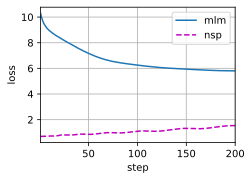

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 200)

In [ ]:
torch.save(net.state_dict(), 'ADL-model.pt')

In [56]:
net.load_state_dict(torch.load('ADL-model.pt'))

<All keys matched successfully>

In [57]:
import pickle

# with open('vocab.pickle', 'wb') as handle:
#     pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('vocab.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [58]:
def get_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(np.expand_dims(np.array(vocab[tokens]), axis=0),device=device).long()
    segments = torch.tensor(np.expand_dims(np.array(segments), axis=0),device=device).long()
    valid_len = torch.tensor(np.expand_dims(np.array(len(tokens)), axis=0),device=device).long()
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [59]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[0, :, :]
encoded_text_crane = encoded_text[2, :, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([6, 1, 256]),
 torch.Size([1, 256]),
 tensor([-7.5800e-06, -6.0115e-07, -9.6022e-10], device='cuda:0',
        grad_fn=<SliceBackward>))

In [60]:
import json
import multiprocessing

In [62]:
my_model=net
vocab=b

In [63]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
class SNLIBERTDataset(gluon.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [
            [[p for p in p_tokens if p not in stop_words], [h for h in h_tokens if h not in stop_words]] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]
        
        self.labels = np.array(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (np.array(all_token_ids, dtype='int32'),
                np.array(all_segments, dtype='int32'), 
                np.array(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]
        # a = torch.tensor(np.array(self.all_token_ids[idx], dtype=np.float32)).long()
        # b = torch.tensor(np.array(self.all_segments[idx], dtype=np.float32)).long()
        # c = torch.tensor(np.array(self.valid_lens[idx], dtype=np.float32))
        # d = torch.tensor(np.array(self.labels[idx], dtype=np.float32)).long()
        # return (a, b, c), d

    def __len__(self):
        return len(self.all_token_ids)

In [65]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 32, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


In [66]:
class BERTClassifier(nn.Module):
    def __init__(self, hidden_dim, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(2*hidden_dim,3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[-1, :, :]))

In [67]:
net = BERTClassifier(hidden_dim,my_model)
net.to(device)
#net.output.initialize(ctx=devices)

BERTClassifier(
  (encoder): LSTMEncoder(
    (token_embedding): Embedding(20256, 200)
    (segment_embedding): Embedding(2, 200)
    (blks): My_Bi_LSTM(
      (rnn_back): ModuleList(
        (0): My_RNN_back(
          (rnn): LSTM(200, 128, dropout=0.2, bidirectional=True)
        )
      )
      (rnn): ModuleList(
        (0): My_RNN(
          (rnn): LSTM(328, 128, dropout=0.2)
        )
      )
    )
  )
  (hidden): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
  )
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [68]:
lr, num_epochs = 1e-4, 4
# trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
# loss = gluon.loss.SoftmaxCrossEntropyLoss()
model2=net
lr=0.0003
optimizer2=optim.Adam(model2.parameters(),lr,weight_decay=0.0001)
criterion2=nn.CrossEntropyLoss()
exp_lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=4, gamma=0.5)



# d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices,
#                d2l.split_batch_multi_inputs)

In [69]:
def train(model,train_loader,val_loader,optimizer,criterion,scheduler,epochs,print_iter=5):
    train_loss=[]
    val_loss=[]
    for i in range(epochs):
        model.train()
        #train_loader.init_epoch()
        running_loss_train=0 
        total=0.0
        for indx,inputs in enumerate(train_loader):
            #inputs=inputs.to(device)
            #labels=labels.to(device)
            inputs,labels=inputs
            a,b,c=inputs
            a = torch.tensor(np.array(a, dtype=np.float32),device=device).long()
            b = torch.tensor(np.array(b, dtype=np.float32),device=device).long()
            c = torch.tensor(np.array(c, dtype=np.float32),device=device)
            labels = torch.tensor(np.array(labels, dtype=np.float32),device=device).long()
            inputs=(a,b,c)
            optimizer.zero_grad()
            output=model(inputs)
            loss=criterion(output,labels)
            running_loss_train+=loss.item()
            loss.backward()
            optimizer.step()
            total+=batch_size
        train_loss.append(running_loss_train/total)
        if (i%print_iter)==0:
            model.eval()
            running_corrects=0.0
            running_loss=0.0
            total=0.0
            with torch.no_grad():
                for inputs in val_loader:
                    #inputs=inputs.to(device)
                    #labels=labels.to(device)
                    inputs,labels=inputs
                    a,b,c=inputs
                    a = torch.tensor(np.array(a, dtype=np.float32),device=device).long()
                    b = torch.tensor(np.array(b, dtype=np.float32),device=device).long()
                    c = torch.tensor(np.array(c, dtype=np.float32),device=device)
                    labels = torch.tensor(np.array(labels, dtype=np.float32),device=device).long()
                    inputs=(a,b,c)
                    optimizer.zero_grad()
                    output=model(inputs)
                    loss=criterion(output,labels)
                    _,pred=torch.max(output, 1)
                    running_corrects += torch.sum(pred == labels).item()
                    running_loss+=loss.item()
                    total+=batch_size
            print(' {} Loss: {:.6f} Acc: {:.6f}'.format(
                  i,running_loss/total,(running_corrects/total)))
            val_loss.append(running_loss/total)
        scheduler.step()
    return model,train_loss,val_loss

In [70]:
_,train_loss,val_loss=train(net,train_iter,test_iter,optimizer2,criterion2,exp_lr_scheduler2,epochs=4,print_iter=1)

 0 Loss: 0.002146 Acc: 0.328711
 1 Loss: 0.002146 Acc: 0.328906
 2 Loss: 0.002145 Acc: 0.328809


Process ForkPoolWorker-57:
Process ForkPoolWorker-71:
Process ForkPoolWorker-62:
Process ForkPoolWorker-58:
Process ForkPoolWorker-70:
Process ForkPoolWorker-61:
Process ForkPoolWorker-63:
Process ForkPoolWorker-72:
Process ForkPoolWorker-59:
Process ForkPoolWorker-64:
Process ForkPoolWorker-60:
Process ForkPoolWorker-67:
Traceback (most recent call last):
Process ForkPoolWorker-69:
Traceback (most recent call last):
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-65:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstra

ValueError: ignored

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kw

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
torch.save(net.state_dict(), '/content/drive/MyDrive/ADL-model.pt') 

In [ ]:
a='Comparing with the PTB dataset, the WikiText-2 dateset retains the original punctuation, case and numbers, and is over twice larger.'
b=' tjeh fdhidf'

dataset=[[a],[b]]
all_premise_hypothesis_tokens = [
            [[p for p in p_tokens if p not in stop_words], [h for h in h_tokens if h not in stop_words]] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset])]
print(all_premise_hypothesis_tokens)

In [ ]:
print(all_premise_hypothesis_tokens)

In [ ]:
d2l.tokenize(dataset)